In [1]:
# !pip install -v python-mecab-ko

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x107f5bfe370>)

# Data Load

In [4]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data.head(2)

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...


In [6]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['sentence']

In [8]:
data[:5]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [11]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [12]:
duplicate = data[data.duplicated()]

In [13]:
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [14]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


<AxesSubplot: >

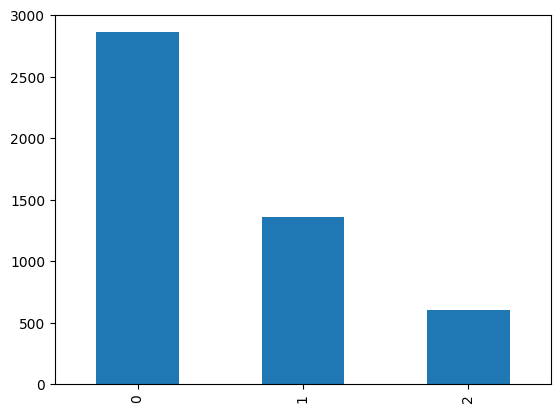

In [15]:
data['labels'].value_counts().plot(kind='bar')

In [16]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [17]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [18]:
mecab = mecab.MeCab()

In [19]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [20]:
data.head(2)

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."


# 훈련-테스트

In [21]:
X_data = data['tokenized']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [23]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966


In [24]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.285%
긍정 = 28.205%
부정 = 12.51%


In [25]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.213%
긍정 = 28.261%
부정 = 12.526%


# tokenize

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[390, 199, 4, 299, 170, 128, 2, 150, 15, 299, 170, 2075, 331, 10, 4, 1156, 5, 567, 29, 20, 22, 151, 10, 16, 14, 3, 1], [1157, 1158, 4, 92, 5, 43, 36, 50, 13, 47, 208, 16, 13, 3, 1], [5, 95, 2, 55, 7, 19, 1, 38, 44, 15, 48, 1, 52, 44, 22, 50, 13, 3, 1], [515, 4, 2076, 4504, 6, 84, 283, 157, 8, 609, 638, 160, 2, 2480, 474, 1066, 157, 6, 2077, 29, 20, 8, 284, 13, 3, 1], [165, 339, 7, 1426, 265, 76, 15, 1426, 332, 76, 699, 18, 475, 212, 1]]
[[868, 792, 7, 113, 140, 6, 88, 332, 27, 17, 12, 114, 77, 1], [97, 1917, 211, 184, 2, 4295, 2503, 23, 401, 24, 770, 6, 174, 364, 34, 16, 190, 61, 20, 5, 69, 28, 330, 7, 51, 13, 3, 1], [672, 160, 376, 882, 30, 238, 31, 4, 156, 2, 3463, 1088, 5, 21, 5286, 159, 2, 964, 12, 2873, 10, 4, 20, 5, 69, 1143, 13, 3, 1], [412, 38, 65, 150, 7, 58, 11, 231, 95, 2, 19, 1, 48, 206, 17, 15, 19, 1, 43, 206, 17, 18, 452, 3, 1], [71, 11, 43, 26, 511, 40, 653, 19, 205, 98, 571, 105, 1, 5241, 2, 1196, 328, 3118, 19, 37, 71, 6, 84, 271, 2474, 7, 71, 11, 19, 26, 123, 38, 26,

In [27]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

8942


## 패딩

In [28]:
X_train[:2]

2049    [보험, 사, 는, 노르, 데, 아, 의, 순이익, 에서, 노르, 데, 아가, 차지...
129     [백화점, 부서, 는, 매출, 이, 4, %, 증가, 했, 다고, 보, 고, 했, ...
Name: tokenized, dtype: object

본문의 최대 길이 : 76
본문의 평균 길이 : 28.235431235431236


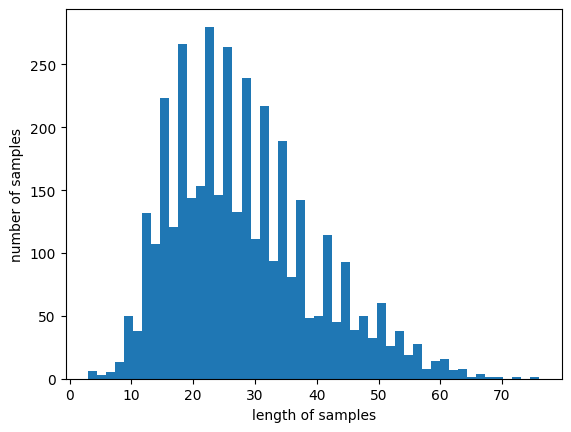

In [29]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
max_len = 76

In [31]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [32]:
X_train_encoded.shape

(3861, 76)

In [33]:
X_test_encoded.shape

(966, 76)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
X_test[:1]

2347    [합작, 법인, 은, 곧바로, 생산, 기술, 에, 약, 50, 만, 유로, 를, 투...
Name: tokenized, dtype: object

In [36]:
X_train_encoded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  390,  199,    4,  299,  170,  128,
          2,  150,   15,  299,  170, 2075,  331,   10,    4, 1156,    5,
        567,   29,   20,   22,  151,   10,   16,   14,    3,    1])

In [37]:
X_train_encoded.shape

(3861, 76)

In [38]:
y_test[8]

1

In [39]:
y_train.shape

(3861,)

In [40]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [41]:
y_train.shape

(3861, 3)

In [42]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
96/97 [============================>.] - ETA: 0s - loss: 0.8751 - acc: 0.6221
Epoch 1: val_acc improved from -inf to 0.70634, saving model to best_model.h5
97/97 [==============================] - 8s 32ms/step - loss: 0.8736 - acc: 0.6234 - val_loss: 0.7014 - val_acc: 0.7063
Epoch 2/15
95/97 [============================>.] - ETA: 0s - loss: 0.5994 - acc: 0.7408
Epoch 2: val_acc improved from 0.70634 to 0.73480, saving model to best_model.h5
97/97 [==============================] - 3s 28ms/step - loss: 0.5995 - acc: 0.7419 - val_loss: 0.6972 - val_acc: 0.7348
Epoch 3/15
95/97 [============================>.] - ETA: 0s - loss: 0.3197 - acc: 0.8819
Epoch 3: val_acc did not improve from 0.73480
97/97 [==============================] - 3s 28ms/step - loss: 0.3205 - acc: 0.8818 - val_loss: 0.7446 - val_acc: 0.7257
Epoch 4/15
95/97 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9510
Epoch 4: val_acc did not improve from 0.73480
97/97 [==========================

In [43]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

31/31 [==============================] - 1s 9ms/step - loss: 1.0395 - acc: 0.7381

 테스트 정확도: 0.7381


In [44]:
loaded_model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model=tf.keras.models.load_model(
    './NLP/best_model.h5')

OSError: No file or directory found at ./NLP/best_model.h5